# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

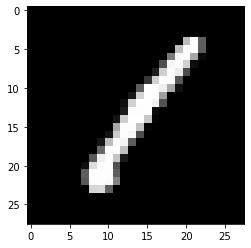

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [4]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_batch128_ensemble" # 設定に変更があった場合ここだけ変更 ensemble
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [5]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 128 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37760/37794 [============================>.] - ETA: 0s - loss: 4.3941 - acc: 0.9579
Epoch 00001: val_loss improved from inf to 3.66805, saving model to img_classifier_model_1_ResNet50_epoch10_batch128_ensemble.h5
37794/37794 [==============================] - 34s 894us/sample - loss: 4.3935 - acc: 0.9579 - val_loss: 3.6680 - val_acc: 0.9717
Epoch 2/10
37760/37794 [============================>.] - ETA: 0s - loss: 3.2316 - acc: 0.9925
Epoch 00002: val_loss improved from 3.66805 to 2.95317, saving model to img_classifier_model_1_ResNet50_epoch10_batch128_ensemble.h5
37794/37794 [==============================] - 22s 582us/sample - loss: 3.2313 - acc: 0.9925 - val_loss: 2.9532 - val_acc: 0.9815
Epoch 3/10
37760/37794 [============================>.] - ETA: 0s - loss: 2.6975 - acc: 0.9982
Epoch 00003: val_loss improved from 2.95317 to 2.54704, saving model to img_classifier_model_1_ResNet50_epoch10_batch128_ensemb

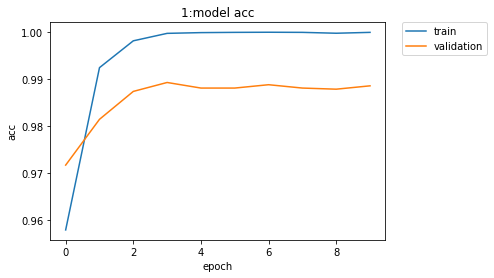

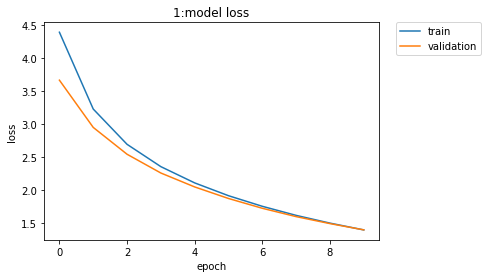

Done compiling best model.


1. Accuracy on validation data: 0.988588
Classification Report
              precision    recall  f1-score   support

           0    0.99277   0.99517   0.99397       414
           1    1.00000   0.99360   0.99679       469
           2    0.98578   0.99522   0.99048       418
           3    0.99080   0.98853   0.98967       436
           4    0.98540   0.99265   0.98901       408
           5    0.98421   0.98421   0.98421       380
           6    0.98317   0.98792   0.98554       414
           7    0.98639   0.98639   0.98639       441
           8    0.99015   0.98771   0.98893       407
           9    0.98551   0.97375   0.97959       419

   micro avg    0.98859   0.98859   0.98859      4206
   macro avg    0.98842   0.98852   0.98846      4206
weighted avg    0.98860   0.98859   0.98858      4206
 samples avg    0.98859   0.98859   0.98859      4206





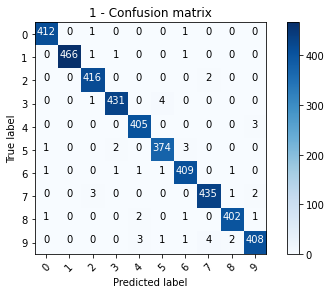

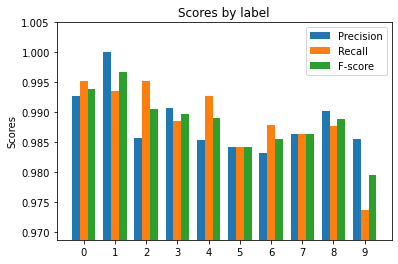

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37760/37796 [============================>.] - ETA: 0s - loss: 4.4036 - acc: 0.9566
Epoch 00001: val_loss improved from inf to 3.67527, saving model to img_classifier_model_2_ResNet50_epoch10_batch128_ensemble.h5
37796/37796 [==============================] - 32s 850us/sample - loss: 4.4029 - acc: 0.9566 - val_loss: 3.6753 - val_acc: 0.9724
Epoch 2/10
37760/37796 [============================>.] - ETA: 0s - loss: 3.2370 - acc: 0.9928
Epoch 00002: val_loss improved from 3.67527 to 2.96192, saving model to img_classifier_model_2_ResNet50_epoch10_batch128_ensemble.h5
37796/37796 [==============================] - 22s 586us/sample - loss: 3.2367 - acc: 0.9928 - val_loss: 2.9619 - val_acc: 0.9831
Epoch 3/10
37760/37796 [============================>.] - ETA: 0s - loss: 2.7028 - acc: 0.9982
Epoch 00003: val_loss improved from 2.96192 to 2.56255, saving model to img_classifier_model_2_ResNet50_epoch10_batch128_ensemb

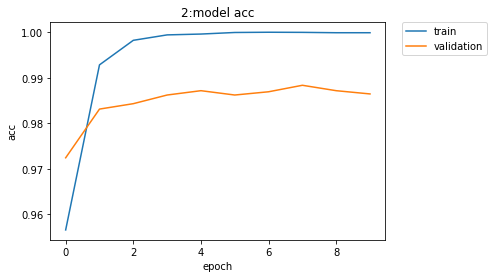

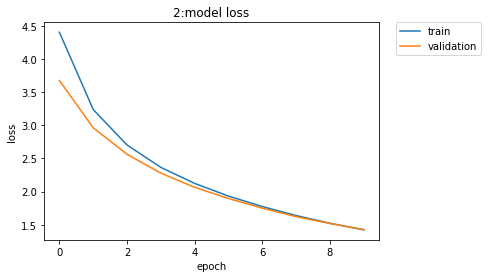

Done compiling best model.


2. Accuracy on validation data: 0.986441
Classification Report
              precision    recall  f1-score   support

           0    0.99517   0.99517   0.99517       414
           1    0.99571   0.98934   0.99251       469
           2    0.97862   0.98565   0.98212       418
           3    0.99068   0.97701   0.98380       435
           4    0.99263   0.99020   0.99141       408
           5    0.97638   0.97895   0.97766       380
           6    0.98325   0.99275   0.98798       414
           7    0.99307   0.97727   0.98511       440
           8    0.98297   0.99263   0.98778       407
           9    0.97406   0.98568   0.97983       419

   micro avg    0.98644   0.98644   0.98644      4204
   macro avg    0.98625   0.98646   0.98634      4204
weighted avg    0.98650   0.98644   0.98645      4204
 samples avg    0.98644   0.98644   0.98644      4204





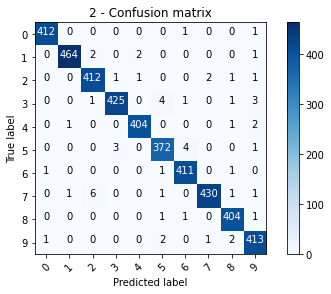

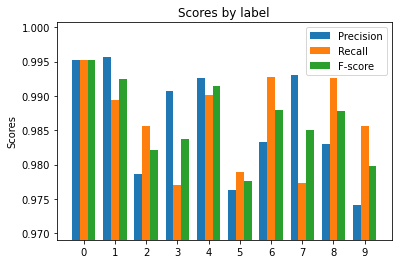

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37760/37798 [============================>.] - ETA: 0s - loss: 4.4079 - acc: 0.9578
Epoch 00001: val_loss improved from inf to 3.65956, saving model to img_classifier_model_3_ResNet50_epoch10_batch128_ensemble.h5
37798/37798 [==============================] - 32s 851us/sample - loss: 4.4073 - acc: 0.9577 - val_loss: 3.6596 - val_acc: 0.9805
Epoch 2/10
37760/37798 [============================>.] - ETA: 0s - loss: 3.2527 - acc: 0.9921
Epoch 00002: val_loss improved from 3.65956 to 2.96796, saving model to img_classifier_model_3_ResNet50_epoch10_batch128_ensemble.h5
37798/37798 [==============================] - 22s 591us/sample - loss: 3.2523 - acc: 0.9921 - val_loss: 2.9680 - val_acc: 0.9855
Epoch 3/10
37760/37798 [============================>.] - ETA: 0s - loss: 2.7206 - acc: 0.9980
Epoch 00003: val_loss improved from 2.96796 to 2.56285, saving model to img_classifier_model_3_ResNet50_epoch10_batch128_ensemb

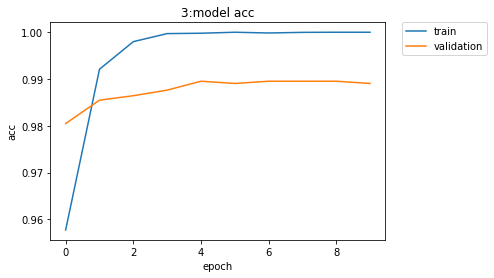

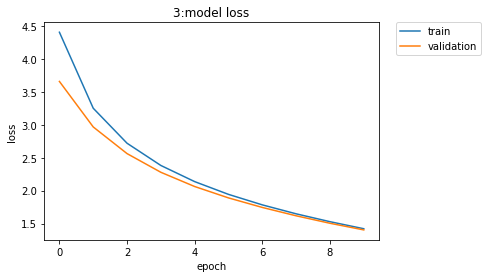

Done compiling best model.


3. Accuracy on validation data: 0.989053
Classification Report
              precision    recall  f1-score   support

           0    0.99274   0.99274   0.99274       413
           1    0.98526   0.99787   0.99153       469
           2    0.98571   0.99043   0.98807       418
           3    0.99078   0.98851   0.98964       435
           4    0.99005   0.97789   0.98393       407
           5    0.99471   0.98947   0.99208       380
           6    0.99041   0.99758   0.99398       414
           7    0.99085   0.98409   0.98746       440
           8    0.98765   0.98280   0.98522       407
           9    0.98337   0.98807   0.98571       419

   micro avg    0.98905   0.98905   0.98905      4202
   macro avg    0.98915   0.98894   0.98904      4202
weighted avg    0.98907   0.98905   0.98905      4202
 samples avg    0.98905   0.98905   0.98905      4202





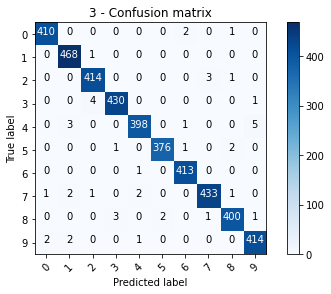

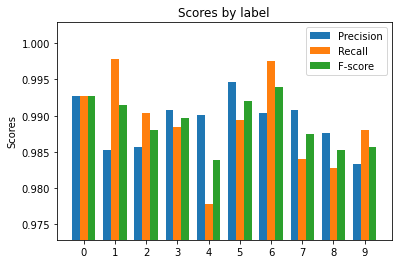

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37760/37799 [============================>.] - ETA: 0s - loss: 4.4379 - acc: 0.9565
Epoch 00001: val_loss improved from inf to 3.73569, saving model to img_classifier_model_4_ResNet50_epoch10_batch128_ensemble.h5
37799/37799 [==============================] - 32s 845us/sample - loss: 4.4371 - acc: 0.9566 - val_loss: 3.7357 - val_acc: 0.9743
Epoch 2/10
37760/37799 [============================>.] - ETA: 0s - loss: 3.2925 - acc: 0.9931
Epoch 00002: val_loss improved from 3.73569 to 3.02482, saving model to img_classifier_model_4_ResNet50_epoch10_batch128_ensemble.h5
37799/37799 [==============================] - 22s 592us/sample - loss: 3.2922 - acc: 0.9931 - val_loss: 3.0248 - val_acc: 0.9845
Epoch 3/10
37760/37799 [============================>.] - ETA: 0s - loss: 2.7589 - acc: 0.9984
Epoch 00003: val_loss improved from 3.02482 to 2.61553, saving model to img_classifier_model_4_ResNet50_epoch10_batch128_ensemb

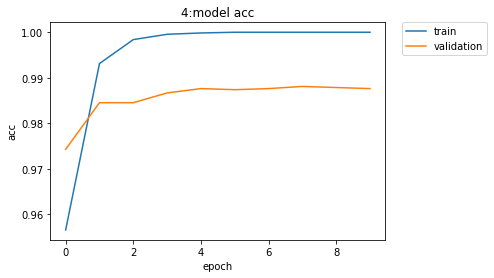

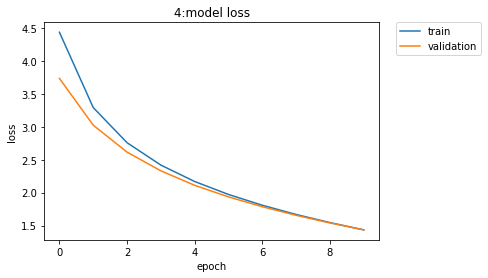

Done compiling best model.


4. Accuracy on validation data: 0.987622
Classification Report
              precision    recall  f1-score   support

           0    0.99277   0.99758   0.99517       413
           1    0.99145   0.98934   0.99039       469
           2    0.98565   0.98565   0.98565       418
           3    0.98618   0.98391   0.98504       435
           4    0.99257   0.98526   0.98890       407
           5    0.99468   0.98421   0.98942       380
           6    0.99036   0.99275   0.99156       414
           7    0.97534   0.98864   0.98194       440
           8    0.98289   0.99015   0.98650       406
           9    0.98558   0.97852   0.98204       419

   micro avg    0.98762   0.98762   0.98762      4201
   macro avg    0.98775   0.98760   0.98766      4201
weighted avg    0.98765   0.98762   0.98762      4201
 samples avg    0.98762   0.98762   0.98762      4201





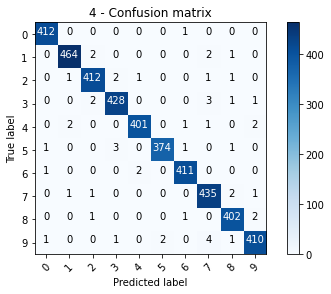

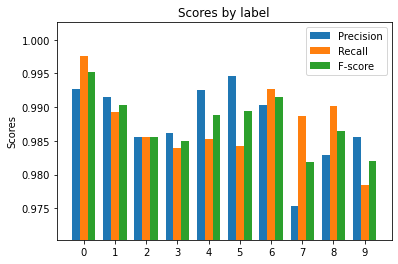

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37760/37800 [============================>.] - ETA: 0s - loss: 4.3993 - acc: 0.9577
Epoch 00001: val_loss improved from inf to 3.66935, saving model to img_classifier_model_5_ResNet50_epoch10_batch128_ensemble.h5
37800/37800 [==============================] - 32s 845us/sample - loss: 4.3985 - acc: 0.9577 - val_loss: 3.6693 - val_acc: 0.9736
Epoch 2/10
37760/37800 [============================>.] - ETA: 0s - loss: 3.2349 - acc: 0.9925
Epoch 00002: val_loss improved from 3.66935 to 2.97846, saving model to img_classifier_model_5_ResNet50_epoch10_batch128_ensemble.h5
37800/37800 [==============================] - 22s 590us/sample - loss: 3.2346 - acc: 0.9925 - val_loss: 2.9785 - val_acc: 0.9762
Epoch 3/10
37760/37800 [============================>.] - ETA: 0s - loss: 2.6999 - acc: 0.9982
Epoch 00003: val_loss improved from 2.97846 to 2.56228, saving model to img_classifier_model_5_ResNet50_epoch10_batch128_ensemb

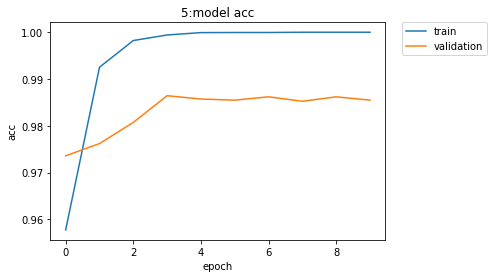

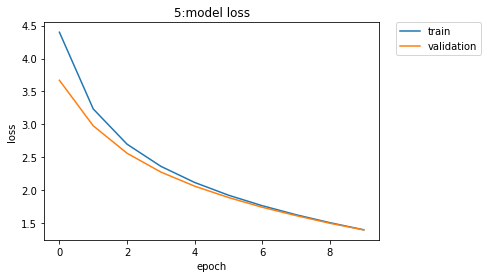

Done compiling best model.


5. Accuracy on validation data: 0.985476
Classification Report
              precision    recall  f1-score   support

           0    0.99277   0.99758   0.99517       413
           1    0.98298   0.98718   0.98507       468
           2    0.97847   0.97847   0.97847       418
           3    0.99307   0.98851   0.99078       435
           4    0.99007   0.98034   0.98519       407
           5    0.99202   0.98158   0.98677       380
           6    0.99036   0.99275   0.99156       414
           7    0.98190   0.98636   0.98413       440
           8    0.97783   0.97783   0.97783       406
           9    0.97630   0.98329   0.97979       419

   micro avg    0.98548   0.98548   0.98548      4200
   macro avg    0.98558   0.98539   0.98548      4200
weighted avg    0.98550   0.98548   0.98548      4200
 samples avg    0.98548   0.98548   0.98548      4200





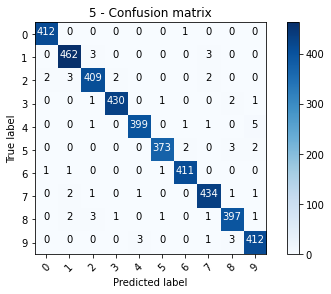

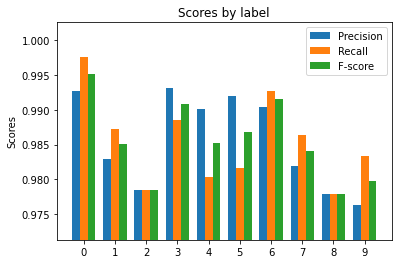

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.4286 - acc: 0.9559
Epoch 00001: val_loss improved from inf to 3.71602, saving model to img_classifier_model_6_ResNet50_epoch10_batch128_ensemble.h5
37801/37801 [==============================] - 32s 851us/sample - loss: 4.4279 - acc: 0.9558 - val_loss: 3.7160 - val_acc: 0.9759
Epoch 2/10
37760/37801 [============================>.] - ETA: 0s - loss: 3.2794 - acc: 0.9928
Epoch 00002: val_loss improved from 3.71602 to 3.01051, saving model to img_classifier_model_6_ResNet50_epoch10_batch128_ensemble.h5
37801/37801 [==============================] - 22s 591us/sample - loss: 3.2791 - acc: 0.9928 - val_loss: 3.0105 - val_acc: 0.9814
Epoch 3/10
37760/37801 [============================>.] - ETA: 0s - loss: 2.7474 - acc: 0.9985
Epoch 00003: val_loss improved from 3.01051 to 2.60318, saving model to img_classifier_model_6_ResNet50_epoch10_batch128_ensemb

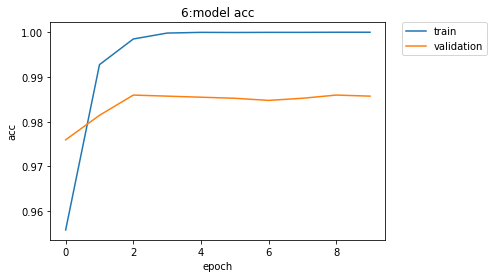

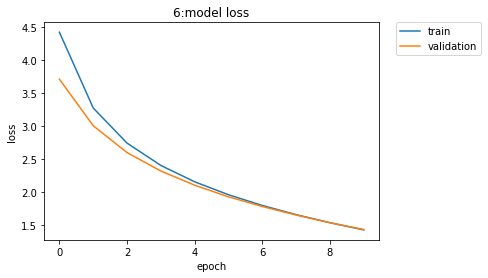

Done compiling best model.


6. Accuracy on validation data: 0.985711
Classification Report
              precision    recall  f1-score   support

           0    0.98313   0.98789   0.98551       413
           1    0.99147   0.99359   0.99253       468
           2    0.98578   0.99522   0.99048       418
           3    0.99070   0.97931   0.98497       435
           4    0.99256   0.98280   0.98765       407
           5    0.98930   0.97625   0.98274       379
           6    0.99029   0.98551   0.98789       414
           7    0.98420   0.99091   0.98754       440
           8    0.96386   0.98522   0.97442       406
           9    0.98558   0.97852   0.98204       419

   micro avg    0.98571   0.98571   0.98571      4199
   macro avg    0.98569   0.98552   0.98558      4199
weighted avg    0.98578   0.98571   0.98572      4199
 samples avg    0.98571   0.98571   0.98571      4199





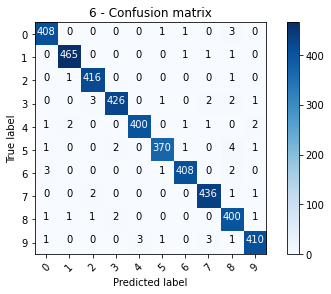

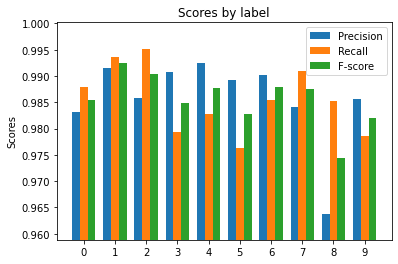

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37760/37801 [============================>.] - ETA: 0s - loss: 4.4492 - acc: 0.9556
Epoch 00001: val_loss improved from inf to 3.72499, saving model to img_classifier_model_7_ResNet50_epoch10_batch128_ensemble.h5
37801/37801 [==============================] - 31s 817us/sample - loss: 4.4484 - acc: 0.9557 - val_loss: 3.7250 - val_acc: 0.9790
Epoch 2/10
37760/37801 [============================>.] - ETA: 0s - loss: 3.3107 - acc: 0.9928
Epoch 00002: val_loss improved from 3.72499 to 3.03832, saving model to img_classifier_model_7_ResNet50_epoch10_batch128_ensemble.h5
37801/37801 [==============================] - 22s 593us/sample - loss: 3.3105 - acc: 0.9928 - val_loss: 3.0383 - val_acc: 0.9802
Epoch 3/10
37760/37801 [============================>.] - ETA: 0s - loss: 2.7762 - acc: 0.9981
Epoch 00003: val_loss improved from 3.03832 to 2.62947, saving model to img_classifier_model_7_ResNet50_epoch10_batch128_ensemb

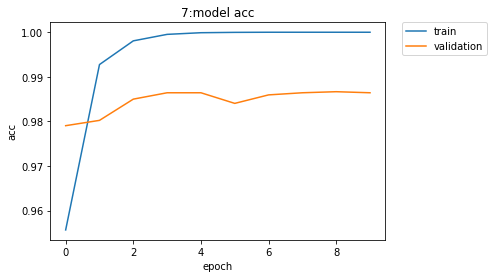

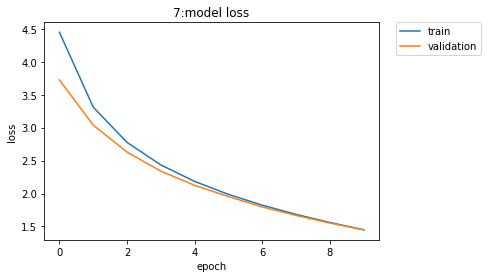

Done compiling best model.


7. Accuracy on validation data: 0.986425
Classification Report
              precision    recall  f1-score   support

           0    0.98801   0.99758   0.99277       413
           1    0.99362   0.99786   0.99574       468
           2    0.97847   0.97847   0.97847       418
           3    0.98843   0.98161   0.98501       435
           4    0.98771   0.98771   0.98771       407
           5    0.98936   0.98153   0.98543       379
           6    0.99034   0.99034   0.99034       414
           7    0.98864   0.98864   0.98864       440
           8    0.98280   0.98522   0.98401       406
           9    0.97608   0.97375   0.97491       419

   micro avg    0.98643   0.98643   0.98643      4199
   macro avg    0.98635   0.98627   0.98630      4199
weighted avg    0.98642   0.98643   0.98642      4199
 samples avg    0.98643   0.98643   0.98643      4199





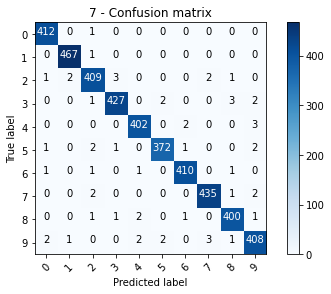

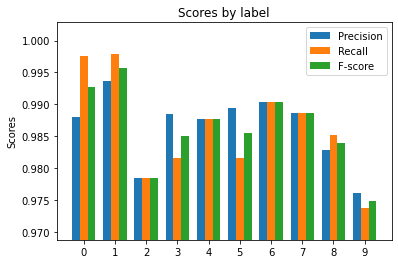

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37760/37803 [============================>.] - ETA: 0s - loss: 4.4051 - acc: 0.9550
Epoch 00001: val_loss improved from inf to 3.68159, saving model to img_classifier_model_8_ResNet50_epoch10_batch128_ensemble.h5
37803/37803 [==============================] - 32s 845us/sample - loss: 4.4042 - acc: 0.9550 - val_loss: 3.6816 - val_acc: 0.9700
Epoch 2/10
37760/37803 [============================>.] - ETA: 0s - loss: 3.2384 - acc: 0.9927
Epoch 00002: val_loss improved from 3.68159 to 2.96677, saving model to img_classifier_model_8_ResNet50_epoch10_batch128_ensemble.h5
37803/37803 [==============================] - 22s 593us/sample - loss: 3.2380 - acc: 0.9927 - val_loss: 2.9668 - val_acc: 0.9828
Epoch 3/10
37760/37803 [============================>.] - ETA: 0s - loss: 2.7038 - acc: 0.9986
Epoch 00003: val_loss improved from 2.96677 to 2.55371, saving model to img_classifier_model_8_ResNet50_epoch10_batch128_ensemb

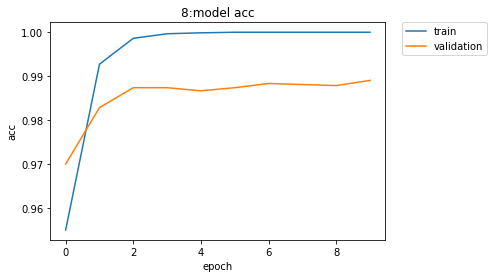

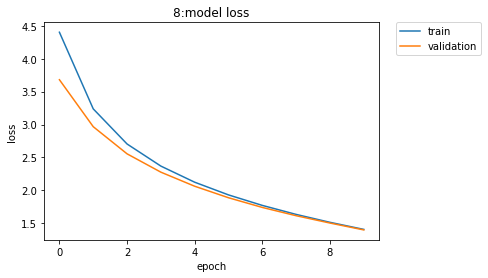

Done compiling best model.


8. Accuracy on validation data: 0.989040
Classification Report
              precision    recall  f1-score   support

           0    0.98568   1.00000   0.99279       413
           1    0.99153   1.00000   0.99574       468
           2    0.99281   0.99281   0.99281       417
           3    0.99766   0.98161   0.98957       435
           4    0.98768   0.98526   0.98647       407
           5    0.99202   0.98417   0.98808       379
           6    0.99270   0.98789   0.99029       413
           7    0.98636   0.98636   0.98636       440
           8    0.97337   0.99015   0.98168       406
           9    0.99036   0.98091   0.98561       419

   micro avg    0.98904   0.98904   0.98904      4197
   macro avg    0.98902   0.98892   0.98894      4197
weighted avg    0.98909   0.98904   0.98904      4197
 samples avg    0.98904   0.98904   0.98904      4197





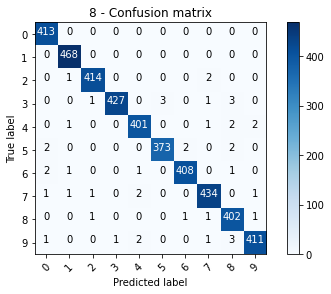

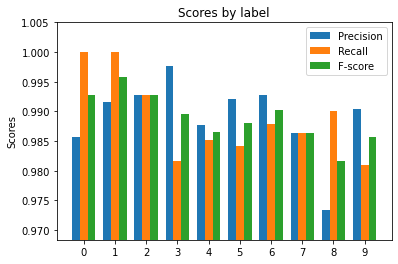

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37760/37804 [============================>.] - ETA: 0s - loss: 4.4117 - acc: 0.9554
Epoch 00001: val_loss improved from inf to 3.66594, saving model to img_classifier_model_9_ResNet50_epoch10_batch128_ensemble.h5
37804/37804 [==============================] - 32s 845us/sample - loss: 4.4108 - acc: 0.9554 - val_loss: 3.6659 - val_acc: 0.9771
Epoch 2/10
37760/37804 [============================>.] - ETA: 0s - loss: 3.2483 - acc: 0.9924
Epoch 00002: val_loss improved from 3.66594 to 2.96391, saving model to img_classifier_model_9_ResNet50_epoch10_batch128_ensemble.h5
37804/37804 [==============================] - 22s 594us/sample - loss: 3.2479 - acc: 0.9924 - val_loss: 2.9639 - val_acc: 0.9881
Epoch 3/10
37760/37804 [============================>.] - ETA: 0s - loss: 2.7134 - acc: 0.9980
Epoch 00003: val_loss improved from 2.96391 to 2.55793, saving model to img_classifier_model_9_ResNet50_epoch10_batch128_ensemb

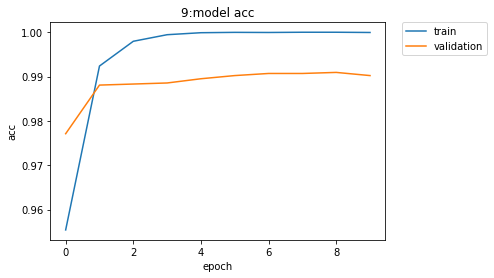

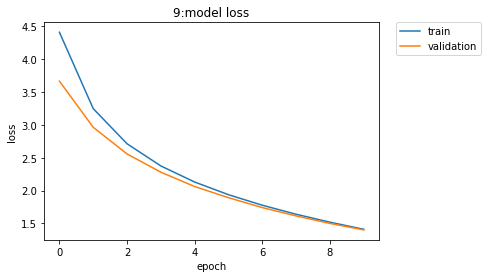

Done compiling best model.


9. Accuracy on validation data: 0.990229
Classification Report
              precision    recall  f1-score   support

           0    0.98798   0.99516   0.99156       413
           1    0.99149   0.99573   0.99360       468
           2    0.99515   0.98321   0.98914       417
           3    0.99766   0.98161   0.98957       435
           4    0.98301   0.99509   0.98901       407
           5    0.99215   1.00000   0.99606       379
           6    0.99274   0.99274   0.99274       413
           7    0.99087   0.98636   0.98861       440
           8    0.97579   0.99261   0.98413       406
           9    0.99515   0.98086   0.98795       418

   micro avg    0.99023   0.99023   0.99023      4196
   macro avg    0.99020   0.99034   0.99024      4196
weighted avg    0.99029   0.99023   0.99023      4196
 samples avg    0.99023   0.99023   0.99023      4196





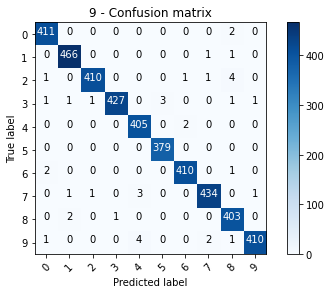

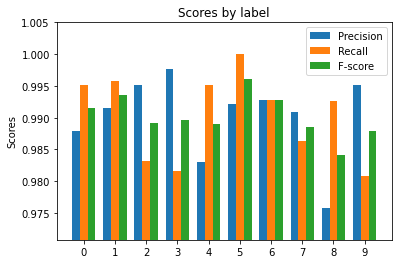

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37760/37804 [============================>.] - ETA: 0s - loss: 4.4345 - acc: 0.9574
Epoch 00001: val_loss improved from inf to 3.71292, saving model to img_classifier_model_10_ResNet50_epoch10_batch128_ensemble.h5
37804/37804 [==============================] - 31s 819us/sample - loss: 4.4336 - acc: 0.9574 - val_loss: 3.7129 - val_acc: 0.9783
Epoch 2/10
37760/37804 [============================>.] - ETA: 0s - loss: 3.2955 - acc: 0.9931
Epoch 00002: val_loss improved from 3.71292 to 3.02909, saving model to img_classifier_model_10_ResNet50_epoch10_batch128_ensemble.h5
37804/37804 [==============================] - 22s 593us/sample - loss: 3.2952 - acc: 0.9931 - val_loss: 3.0291 - val_acc: 0.9816
Epoch 3/10
37760/37804 [============================>.] - ETA: 0s - loss: 2.7654 - acc: 0.9982
Epoch 00003: val_loss improved from 3.02909 to 2.62887, saving model to img_classifier_model_10_ResNet50_epoch10_batch128_en

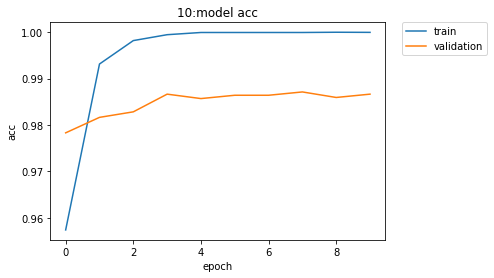

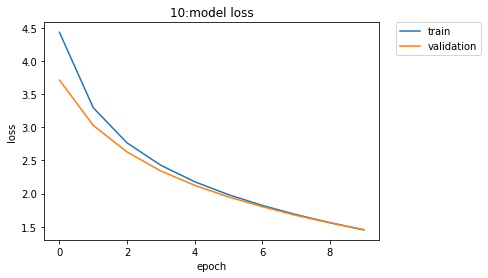

Done compiling best model.


10. Accuracy on validation data: 0.986654
Classification Report
              precision    recall  f1-score   support

           0    0.99512   0.98789   0.99149       413
           1    0.99143   0.98932   0.99037       468
           2    0.98812   0.99760   0.99284       417
           3    0.99070   0.97931   0.98497       435
           4    0.97805   0.98526   0.98164       407
           5    0.99206   0.98945   0.99075       379
           6    0.98565   0.99758   0.99158       413
           7    0.97955   0.97955   0.97955       440
           8    0.98753   0.97537   0.98141       406
           9    0.97862   0.98565   0.98212       418

   micro avg    0.98665   0.98665   0.98665      4196
   macro avg    0.98668   0.98670   0.98667      4196
weighted avg    0.98668   0.98665   0.98665      4196
 samples avg    0.98665   0.98665   0.98665      4196





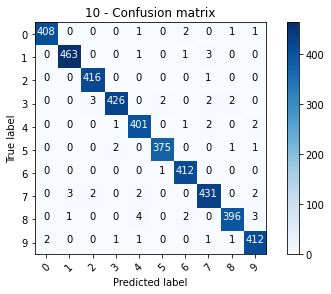

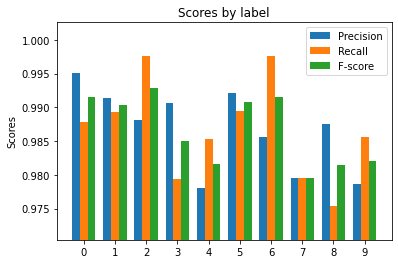

In [6]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
if "ensemble" in model_name:
    for i in glob.glob("*model*"+model_name+"*"+"h5"):
        shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.987524
Classification Report
              precision    recall  f1-score   support

           0    0.99060   0.99468   0.99263      4132
           1    0.99148   0.99338   0.99243      4684
           2    0.98544   0.98827   0.98685      4177
           3    0.99165   0.98299   0.98730      4351
           4    0.98795   0.98625   0.98710      4072
           5    0.98967   0.98498   0.98732      3795
           6    0.98891   0.99178   0.99035      4137
           7    0.98568   0.98546   0.98557      4401
           8    0.98042   0.98597   0.98319      4063
           9    0.98301   0.98090   0.98195      4188

   micro avg    0.98752   0.98752   0.98752     42000
   macro avg    0.98748   0.98747   0.98747     42000
weighted avg    0.98753   0.98752   0.98752     42000
 samples avg    0.98752   0.98752   0.98752     42000





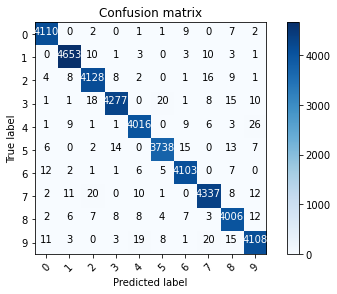

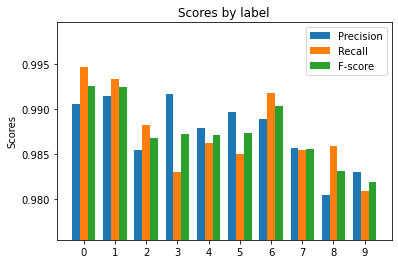

In [7]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

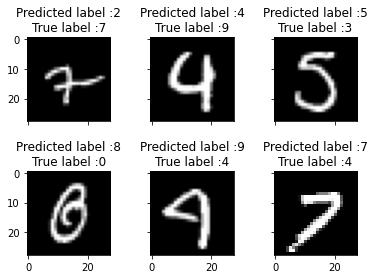

In [8]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 31s 737us/sample - loss: 4.2829 - acc: 0.9587
Epoch 2/10
42000/42000 [==============================] - 23s 549us/sample - loss: 3.0731 - acc: 0.9923
Epoch 3/10
42000/42000 [==============================] - 23s 551us/sample - loss: 2.5410 - acc: 0.9981
Epoch 4/10
42000/42000 [==============================] - 23s 553us/sample - loss: 2.2104 - acc: 0.9996
Epoch 5/10
42000/42000 [==============================] - 23s 553us/sample - loss: 1.9716 - acc: 0.9999
Epoch 6/10
42000/42000 [==============================] - 23s 555us/sample - loss: 1.7839 - acc: 1.0000
Epoch 7/10
42000/42000 [==============================] - 24s 564us/sample - loss: 1.6284 - acc: 1.0000
Epoch 8/10
42000/42000 [==============================] - 24s 564us/sample - loss: 1.4952 - acc: 1.0000
Epoch 9/10
42000/42000 [==============================] - 24s 566us/sample - loss: 1.3794 - acc: 0.9998
Epoch 10/10
42000/42000 [================

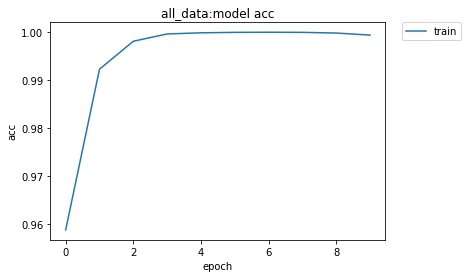

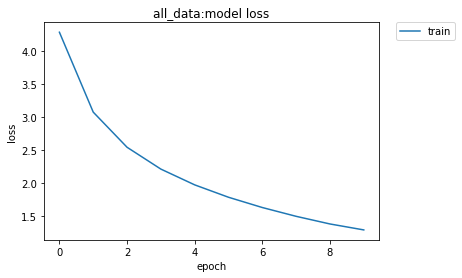

In [9]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [10]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

514797

# 6. Ensemble model test

In [11]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)